### Based on the paper from Goodwill et al.

In [17]:
import math

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from tqdm import tqdm

from tools.traceloader import ASCAD, TraceCategory

sns.set_style("whitegrid")

trace_len = 50
sample_size = 350

def gen_trace(key=0, mu=128):
    return np.array([np.random.normal(mu + (key/256 - 1), 1, trace_len) for _ in range(sample_size)], dtype=np.uint8)

def gen_mask_trace(mu=128):
    random_keys = np.random.uniform(0, 256, sample_size) / 256

    return np.array([np.random.normal(mu + (rk - 1), 1, trace_len) for rk in random_keys], dtype=np.uint8)

tg_a1 = gen_trace(0)
tg_a2 = gen_trace(256)
tg_b = gen_mask_trace()

gen_mask_trace()

array([[129, 128, 127, ..., 128, 126, 129],
       [127, 128, 127, ..., 128, 127, 126],
       [128, 128, 127, ..., 127, 127, 127],
       ...,
       [125, 126, 129, ..., 128, 128, 127],
       [127, 128, 127, ..., 129, 126, 127],
       [126, 126, 127, ..., 128, 125, 125]], dtype=uint8)

In [18]:
def confidence_level(all_t_values, p=.95):
    tvs_flat = abs(all_t_values.flatten())
    n = round(len(tvs_flat) * p)

    return sorted(tvs_flat)[n]

def device_fails(ta: np.array, tb: np.array, c=2.5):
    """
    @param ta should be a positive-valued array of t-test results from some power trace with given key.
    @param tb should be a positive-valued array of t-test results from a different set of traces with the same key.
    @param c should be the confidence value.
    """
    return np.array((ta >= c) * (tb >= c)).any()

def t_test(a, b):
    num = a.mean(axis=0) - b.mean(axis=0)
    den = (((a.var(axis=0) / len(a)) + (b.var(axis=0) / len(b))) ** .5)

    return np.array(num / den)

def stats_t_test(a, b):
    return stats.ttest_ind(a, b, equal_var=False)[0]

def gen_rvs(mean=5):
    return lambda: np.array([stats.norm.rvs(loc=mean,scale=.1,size=50) for _ in range(50)])

def tvla(test, lefts, rights):
    a, b, c, d = lefts
    x, y = rights

    tk1 = abs(np.array(test(a, c)))
    tk2 = abs(np.array(test(b, d)))
    tm1 = abs(np.array(test(a, x)))
    tm2 = abs(np.array(test(b, y)))

    confidence = np.percentile(np.array([*tk1, *tk2, *tm1, *tm2]).flatten(), 95)

    return device_fails(tk1, tk2, confidence), device_fails(tm1, tm2, confidence)

def bench(test, gen_one, gen_two, total=100):
    acc = np.array([(False, False)] * total)
    for ix in tqdm(range(total)):
        acc[ix] = tvla(test, [gen_one() for _ in range(4)], (gen_two(), gen_two()))

    return np.array(acc).sum(axis=0)

In [19]:
# bench(t_test, gen_rvs(5), gen_rvs(6))

In [20]:
# bench(t_test, gen_trace, gen_mask_trace)

In [21]:
ascad = ASCAD()

In [22]:
def smote(trace_categories, target_size):
    def get_point(traces):
        t_shape = traces.shape
        x, y = 0, 0
        while x == y:
            x, y = np.random.randint(t_shape[0]), np.random.randint(t_shape[0])

        smoted_diff = (np.array(traces[y], dtype=int) - np.array(traces[x], dtype=int)) * np.random.uniform(size=t_shape[1])
        smoted_diff = np.array([np.array(t, dtype=np.uint8) for t in smoted_diff])

        return traces[x] + smoted_diff

    acc = []

    for c_ix, category in enumerate(trace_categories):
        res = np.zeros((len(category), target_size, category[0].shape[1]), dtype=np.uint8)

        for s_ix, trace_slice in enumerate(category):
            app = [get_point(trace_slice) for _ in range(target_size - len(trace_slice))]

            if len(app) > 0:
                res[s_ix] = np.concatenate((trace_slice, app))
            else:
                res[s_ix] = trace_slice

        acc.append(res)

    return acc

In [23]:
class CTableStore:
    def __init__(self, tc: TraceCategory, cache=""):
        try:
            self.tables = cache_np(cache)
        except FileNotFoundError:
            self.tc = tc
            self.size = max([math.ceil(len(self.tc.filter_traces(k)) / 2) for k in range(256)])

            self.num_keys = 1
            if cache != "":
                self.num_keys = 256

            self.slices = {}
            self.gen_slices()

            self.smoted = {}
            for k in tqdm(range(self.num_keys), "SMOTEing traces"):
                self.smoted[k] = np.array(smote(self.slices[k], self.size))

            self.tables = {}
            self.gen_tables()

            cache_np(cache, lambda: self.tables)

    def gen_slices(self):
        res = {}

        for k in tqdm(range(self.num_keys), "Slicing up traces"):
            # Transforms traces to uint8
            ts = self.tc.filter_traces(k) + 128
            uts = np.array([np.array(t, dtype=np.uint8) for t in ts])

            np.random.shuffle(uts)
            ts4 = np.array(np.array_split(uts.copy(), 4))
            np.random.shuffle(uts)
            ts2 = np.array(np.array_split(uts, 2))

            res[k] = np.array([ts4, ts2])

        self.slices = res

    def gen_tables(self):
        res = {}

        for k in tqdm(range(self.num_keys), "Generating contingency tables"):
            res[k] = {}
            for c, category in enumerate(self.smoted[k]):
                res[k][c] = {}
                for s, trace_slice in enumerate(category):
                    ts = np.moveaxis(trace_slice, 0, -1)
                    res[k][c][s] = np.array([np.bincount(t, minlength=256) for t in ts])

        self.tables = res

Generating contingency tables: 100%|██████████| 1/1 [00:00<00:00, 39.72it/s]


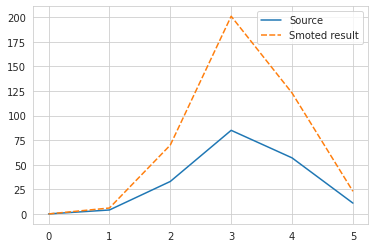

In [24]:
from tools.cache import cache_np

CTableStore(ascad.default.profile, "ctable/ascad_default")
CTableStore(ascad.masked.profile, "ctable/ascad_masked")

cts = CTableStore(ascad.default.profile)

print(cts)

test_cts_split = np.array([i[0] for i in cts.slices[0][0][0]])
test_cts_data = np.array([i[0] for i in cts.smoted[0][0][0]])

sns.lineplot(data=pd.DataFrame(zip(np.bincount(test_cts_split)[-6:], np.bincount(test_cts_data)[-6:]), columns=["Source", "Smoted result"]))

assert np.all(cts.tables[0][0][0][0] == np.bincount(test_cts_data, minlength=256))

In [25]:
print("foo")

foo


In [26]:
cts_m = cache_np("ctable_ascad_masked", CTableStore, ascad.masked.profile)

<AxesSubplot:>

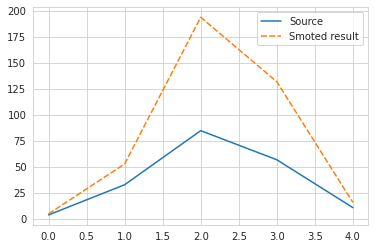

In [27]:
test_sample_pt = np.array([i[0] for i in cts.slices[0][0][0]])
test_sample_pt_smote = np.array([i[0] for i in np.array(smote(cts.slices[0], 400)[0][0])])

assert min(test_sample_pt) == min(test_sample_pt_smote)
assert max(test_sample_pt) == max(test_sample_pt_smote)

bc_spt = np.bincount(test_sample_pt + 128)[-5:]
bc_spt_s = np.bincount(test_sample_pt_smote)[-5:]

sns.lineplot(data=pd.DataFrame(zip(bc_spt, bc_spt_s), columns=["Source", "Smoted result"]))

In [28]:
trc = np.array([round(np.random.uniform(0, 255)) for _ in range(100000)])

def ctable_mv(ctable: np.array, num_observations: int):
    """
    Calculates the mean and variance from a contingency table with a corresponding number of observations.
    """
    # Using 128-bit floats prevents some rounding errors when comparing with the np implementation of var and mean.
    ixs = np.arange(0, len(ctable), dtype=np.float128)

    mu = (ctable * ixs).sum() / num_observations
    sigma2 = ((ctable * ixs ** 2).sum() / num_observations) - (mu ** 2)

    return mu, sigma2

print(ctable_mv(np.bincount(trc, minlength=256), len(trc)))

# Actual mean and variance
trc.mean(), trc.var()

(127.66491, 5405.9315046919)


(127.66491, 5405.9315046919)

In [29]:
# Bench for CTable




In [30]:
def plot_longform(traces):
    sns.set_style('whitegrid')

    longform = []
    for trace in traces:
        for ix in range(len(trace)):
            longform.append((ix, trace[ix]))

    cols = ["Sample point", "Power"]
    df = pd.DataFrame(longform, columns=cols)
    sns.lineplot(data=df, x=cols[0], y=cols[1])

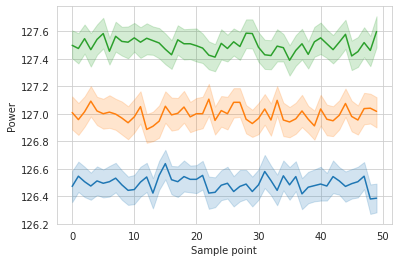

In [31]:
plot_longform(gen_trace(0))
plot_longform(gen_mask_trace())
plot_longform(gen_trace(256))